<a href="https://colab.research.google.com/github/adidror005/youtube-videos/blob/main/LLAMA_3_Fine_Tuning_for_Sequence_Classification_Actual_Video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LLAMA3 Fine-tuning for text classification using QLORA


### Requirements:
* A GPU with enough memory!

### Installs
* They suggest using latest version of transformers
* Must restart after install because the accelerate package used in the hugging face trainer requires it.

In [2]:
# Install Pytorch
# ! pip install "torch==2.5.0" tensorboard

In [3]:
# %pip install  --upgrade "transformers==4.40.0" 
# ! pip install transformers

In [4]:
# ! pip install datasets

In [5]:
# ! pip install accelerate

In [6]:
# ! pip install evaluate 

In [7]:
# ! pip install bitsandbytes

In [8]:
# ! pip install huggingface_hub

In [9]:
# ! pip install trl

In [10]:
# ! pip install peft

In [14]:


# # Install Hugging Face libraries
# %pip install  --upgrade "transformers==4.40.0" "datasets==2.18.0" "accelerate==0.29.3" "evaluate==0.4.1" "bitsandbytes==0.43.1" "huggingface_hub==0.22.2" "trl==0.8.6" "peft==0.10.0"


### Big Picture Overview of Parameter Efficient Fine Tuning Methods like LoRA and QLoRA Fine Tuning for Sequence Classification

**The Essence of Fine-tuning**
- LLMs are pre-trained on vast amounts of data for broad language understanding.
- Fine-tuning is crucial for specializing in specific domains or tasks, involving adjustments with smaller, relevant datasets.

**Model Fine-tuning with PEFT: Exploring LoRA and QLoRA**
- Traditional fine-tuning is resource-intensive; PEFT (Parameter Efficient Fine-tuning) makes the process faster and less demanding.
- Focus on two PEFT methods: LoRA and QLoRA.

**The Power of PEFT**
- PEFT modifies only a subset of the LLM's parameters, enhancing speed and reducing memory demands, making it suitable for less powerful devices.

**LoRA: Efficiency through Adapters**
- **Low-Rank Adaptation (LoRA):** Injects small trainable adapters into the pre-trained model.
- **Equation:** For a weight matrix $W$, LoRA approximates $W = W_0 + BA$, where $W_0$ is the original weight matrix, and $BA$ represents the low-rank modification through trainable matrices $B$ and $A$.
- Adapters learn task nuances while keeping the majority of the LLM unchanged, minimizing overhead.

**QLoRA: Compression and Speed**
- **Quantized LoRA (QLoRA):** Extends LoRA by quantizing the model’s weights, further reducing size and enhancing speed.
- **Innovations in QLoRA:**
  1. **4-bit Quantization:** Uses a 4-bit data type, NormalFloat (NF4), for optimal weight quantization, drastically reducing memory usage.
  2. **Low-Rank Adapters:** Fine-tuned with 16-bit precision to effectively capture task-specific nuances.
  3. **Double Quantization:** Reduces quantization constants from 32-bit to 8-bit, saving additional memory without accuracy loss.
  4. **Paged Optimizers:** Manages memory efficiently during training, optimizing for large tasks.

**Why PEFT Matters**
- **Rapid Learning:** Speeds up model adaptation.
- **Smaller Footprint:** Eases deployment with reduced model size.
- **Edge-Friendly:** Fits better on devices with limited resources, enhancing accessibility.

**Conclusion**
- PEFT methods like LoRA and QLoRA revolutionize LLM fine-tuning by focusing on efficiency, facilitating faster adaptability, smaller models, and broader device compatibility.




### Fine-tuning for Sentiment Analysis Classification:


#### 1. Text Generation with Sentiment Label as part of text
- **Approach**: Train the model to generate text that naturally appends the sentiment label at the end.
- **Input**: "TSLA slashes model Y prices ======"
- **Output**: "TSLA slashes model Y prices ====== Bearish"
- **Use Case**: This method is useful for applications requiring continuous text output that includes embedded sentiment analysis, such as interactive chatbots or automated content creation tools.


#### 2. Sequence Classification Head
- **Approach**: Add a sequence classification head (linear layer) on top of the LLaMa Model transformer. This setup is similar to GPT-2 and focuses on classifying the sentiment based on the last relevant token in the sequence.
    - **Token Positioning**:
        - **With pad_token_id**: The model identifies and ignores padding tokens, using the last non-padding token for classification.
        - **Without pad_token_id**: It defaults to the last token in each sequence.
        - **inputs_embeds**: If embeddings are directly passed (without input_ids), the model cannot identify padding tokens and takes the last embedding in each sequence as the input for classification.
- **Input**: Specific sentences (e.g., "TSLA slashes Model Y prices").
- **Output**: Direct sentiment classification (e.g., "Bearish").
- **Training Objective**: Minimize cross-entropy loss between the predicted and the actual sentiment labels.

https://huggingface.co/docs/transformers/main/en/model_doc/llama

### Peft Configs
* Bits and bytes config for quantization
* Lora config for lora

### Going to use Hugginface Transformers trainer class: Main componenents
* Hugging face dataset (for train + eval)
* Data collater
* Compute Metrics
* Class weights since we use custom trainer and also custom weighted loss..
* trainingArgs: like # epochs, learning rate, weight decay etc..



### Login to huggingface hub to put your LLama token so we can access Llama 3 7B Param Pre-trained Model

In [48]:
#  !huggingface-cli login # can not used through epo tip platform

### Alternative to hugging face -cli

In [56]:
# ! pip install huggingface_hub

In [57]:
# from huggingface_hub import login
# login(token="your token")

###### Imports

In [1]:
import os
import random
import functools
import csv
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import evaluate

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, classification_report, balanced_accuracy_score, accuracy_score

from datasets import Dataset, DatasetDict
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model

from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)


/home/lephuonglantran/.conda/envs/gpuenv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Youtube Video Describing How to get Dataset
* Only really need first 3 mins of video

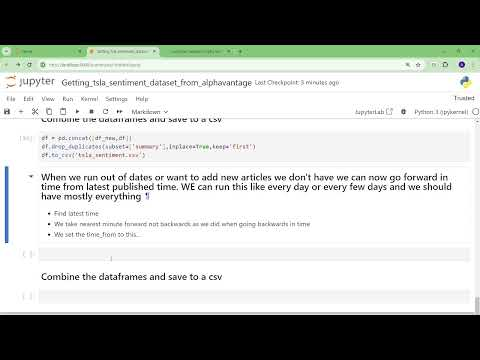

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('ascf3y7zSaY')

#### Load TSLA sentiment analysis dataset
* Derived from Alpha vantage text data...


In [2]:
# df = pd.read_csv("tsla_sentiment.csv")
# df

# ref: 
# [1] https://pandas.pydata.org/docs/reference/api/pandas.concat.html
# [2] https://www.usepandas.com/csv/append-csv-files
# combine pandas csv
df_1 = pd.read_csv("/home/lephuonglantran/EPO2024/df_combine.csv")
print(f"row counts in df_1: {len(df_1)}")
df_2 = pd.read_csv("/home/lephuonglantran/EPO2024/df_combine_val.csv")
print(f"row counts in df_2: {len(df_2)}")
df = pd.concat([df_1, df_2], ignore_index=True)

print(f"row counts in df_epo: {len(df)}")

row counts in df_1: 1848
row counts in df_2: 22
row counts in df_epo: 1870


In [3]:
# df

* Add also a numeric 0,1,2 version of label since we will need it later for fine tuning. We can save it in 'target'

In [4]:
# df['label']=df['label'].astype('category')
# df['target']=df['label'].cat.codes

# df.head()

df['ipc']=df['ipc'].astype('category')
df['target']=df['ipc'].cat.codes
df.head()

,title,description,claims,ipc,target
0,METHOD FOR MULTIPLEX NUCLEIC ACID ANALYSIS,FIELD OF INVENTIONThe present invention relate...,A method of assaying nucleic acids in a sample...,C,2
1,METHODS FOR ISOLATING BACTERIA,The present invention discloses compositions a...,A method to identify or isolate a bacterium wh...,C,2
2,"EMULSIFYING DISPERSANTS, METHOD FOR EMUSIFICAT...",TECHNICAL FIELDThe present invention relates t...,"An emulsification dispersant, wherein the main...",B,1
3,Silibinin component for the treatment of hepat...,This invention relates to the use of a silibin...,A silibinin component for use in the treatment...,A,0
4,Zone detection in a GNSS system,"The present invention concerns, according to a...",Method for zone based detection of vehicles pa...,G,6


* Suppose you want to decode later

In [5]:
# IMPORTANT: in order to use this, if we already run the previous code,
# then we have to rerun the following: (before running the .cat.categories)
df_decode = pd.read_csv("/home/lephuonglantran/EPO2024/df_combine.csv")
df_decode['ipc']=df_decode['ipc'].astype('category')

# df['label'].cat.categories
df_decode['ipc'].cat.categories

Index(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'], dtype='object')

In [6]:
# category_map = {code: category for code, category in enumerate(df['label'].cat.categories)}
# category_map
category_map = {code: category for code, category in enumerate(df_decode['ipc'].cat.categories)}
category_map

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H'}

### Split into train/val/test for later comparison.
* For simplicity we split based on time.
  - First 60% train
  - Next 20% val
  - Next 20% test
* This can be problematic a bit since class balance changes over time and some articles on boundries between train/val or val/test have some overlap, but completely beats bias of stratified sample usually used since some articles are literally on same thing, but maybe different sources.


In [7]:
train_end_point = int(df.shape[0]*0.6)
val_end_point = int(df.shape[0]*0.8)
df_train = df.iloc[:train_end_point,:]
df_val = df.iloc[train_end_point:val_end_point,:]
df_test = df.iloc[val_end_point:,:]
print(df_train.shape, df_test.shape, df_val.shape)



(1122, 5) (374, 5) (374, 5)


### Convert from Pandas DataFrame to Hugging Face Dataset
* Also let's shuffle the training set.
* We put the components train,val,test into a DatasetDict so we can access them later with HF trainer.
* Later we will add a tokenized dataset


In [8]:
# Converting pandas DataFrames into Hugging Face Dataset objects:
# dataset_train = Dataset.from_pandas(df_train.drop('label',axis=1))
# dataset_val = Dataset.from_pandas(df_val.drop('label',axis=1))
# dataset_test = Dataset.from_pandas(df_test.drop('label',axis=1))

dataset_train = Dataset.from_pandas(df_train.drop('ipc',axis=1))
dataset_val = Dataset.from_pandas(df_val.drop('ipc',axis=1))
dataset_test = Dataset.from_pandas(df_test.drop('ipc',axis=1))

In [9]:
# Shuffle the training dataset
dataset_train_shuffled = dataset_train.shuffle(seed=42)  # Using a seed for reproducibility


In [10]:
# Combine them into a single DatasetDict
dataset = DatasetDict({
    'train': dataset_train_shuffled,
    'val': dataset_val,
    'test': dataset_test
})
dataset

DatasetDict({
    train: Dataset({
        features: ['title', 'description', 'claims', 'target'],
        num_rows: 1122
    })
    val: Dataset({
        features: ['title', 'description', 'claims', 'target'],
        num_rows: 374
    })
    test: Dataset({
        features: ['title', 'description', 'claims', 'target'],
        num_rows: 374
    })
})

In [12]:
# dataset['train']

* Since our classes are not balanced let's calculate class weights based on inverse value counts
* Convert to pytorch tensor since we will need it

In [13]:
df_train.target.value_counts(normalize=True)

target
2    0.349376
0    0.215686
6    0.151515
7    0.115865
1    0.103387
5    0.032977
4    0.018717
3    0.012478
Name: proportion, dtype: float64

In [14]:
class_weights=(1/df_train.target.value_counts(normalize=True).sort_index()).tolist()
class_weights=torch.tensor(class_weights)
class_weights=class_weights/class_weights.sum()
class_weights


tensor([0.0236, 0.0493, 0.0146, 0.4083, 0.2722, 0.1545, 0.0336, 0.0440])

## Load LLama model with 4 bit quantization as specified in bits and bytes and prepare model for peft training

### Model Name

In [21]:
# can not access even with the hugging face token (bcs of tip restriction?)
# model_name = "meta-llama/Meta-Llama-3-8B" 

# can access wihtout access token, but its architecture is not conformed with PEFT:
# error:  model that doesn't have the expected projection layers (q_proj, k_proj, v_proj, o_proj) in the architecture.
# when running: get_peft_model
# model_name = "bigscience/bloom-560m" 
model_name = "EleutherAI/gpt-neo-1.3B"


#### Quantization Config (for QLORA)

In [22]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit = True, # enable 4-bit quantization
    bnb_4bit_quant_type = 'nf4', # information theoretically optimal dtype for normally distributed weights
    bnb_4bit_use_double_quant = True, # quantize quantized weights //insert xzibit meme
    bnb_4bit_compute_dtype = torch.bfloat16 # optimized fp format for ML
)


#### Lora Config

In [23]:
lora_config = LoraConfig(
    r = 16, # the dimension of the low-rank matrices
    lora_alpha = 8, # scaling factor for LoRA activations vs pre-trained weight activations
    target_modules = ['q_proj', 'k_proj', 'v_proj', 'o_proj'],
    lora_dropout = 0.05, # dropout probability of the LoRA layers
    bias = 'none', # wether to train bias weights, set to 'none' for attention layers
    task_type = 'SEQ_CLS'
)

#### Load model
* AutomodelForSequenceClassification
* Num Labels is # of classes


In [93]:
# chatGPT:
# ask: how to Ensure you have access to the model meta-llama/Meta-Llama-3-8B on Hugging Face?
# [2] How to use Huggingface trainer API: https://huggingface.co/learn/llm-course/en/chapter3/3
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    quantization_config=quantization_config,
    # num_labels=3
    num_labels=8 # must be determined correctly,
                 # otherwise, unreasonable errors happen to 
                 # CustomedTrainer(Trainer) in the compute_loss function
)

model 

`low_cpu_mem_usage` was None, now default to True since model is quantized.
Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-1.3B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPTNeoForSequenceClassification(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 2048)
    (wpe): Embedding(2048, 2048)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPTNeoBlock(
        (ln_1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
            (v_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
            (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
            (out_proj): Linear4bit(in_features=2048, out_features=2048, bias=True)
          )
        )
        (ln_2): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear4bit(in_features=2048, out_features=81

* prepare_model_for_kbit_training() function to preprocess the quantized model for training.

In [94]:
model = prepare_model_for_kbit_training(model)
model

GPTNeoForSequenceClassification(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 2048)
    (wpe): Embedding(2048, 2048)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPTNeoBlock(
        (ln_1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
            (v_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
            (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
            (out_proj): Linear4bit(in_features=2048, out_features=2048, bias=True)
          )
        )
        (ln_2): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear4bit(in_features=2048, out_features=81

* get_peft_model prepares a model for training with a PEFT method such as LoRA by wrapping the base model and PEFT configuration with get_peft_model

In [95]:
model = get_peft_model(model, lora_config)
model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): GPTNeoForSequenceClassification(
      (transformer): GPTNeoModel(
        (wte): Embedding(50257, 2048)
        (wpe): Embedding(2048, 2048)
        (drop): Dropout(p=0.0, inplace=False)
        (h): ModuleList(
          (0-23): 24 x GPTNeoBlock(
            (ln_1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
            (attn): GPTNeoAttention(
              (attention): GPTNeoSelfAttention(
                (attn_dropout): Dropout(p=0.0, inplace=False)
                (resid_dropout): Dropout(p=0.0, inplace=False)
                (k_proj): lora.Linear4bit(
                  (base_layer): Linear4bit(in_features=2048, out_features=2048, bias=False)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.05, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=2048, out_features=16, bias=False)
  

### Load the tokenizer

#### Since LLAMA3 pre-training doesn't have EOS token
* Set the pad_token_id to eos_token_id
* Set pad token ot eos_token

In [96]:
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)

tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.pad_token = tokenizer.eos_token

#### Update some model configs
* Must use .cache = False as below or it crashes from my experience

In [97]:
model.config.pad_token_id = tokenizer.pad_token_id
model.config.use_cache = False
model.config.pretraining_tp = 1

### Loop through dataset to measure performance before training/fitting the model
* Use a batch size 32 to kinda vectorize and to avoid memory errors.

In [98]:
# sentences = df_test.summary.tolist()
# sentences[0:2]

sentences = df_test.claims.tolist()
sentences[0:2]

['An enhanced monitoring system that identifies an event candidate within a wireless node network, the system comprising: a server (100) disposed at a top level within the wireless node network;a plurality of ID nodes (120a-120e) disposed at a low level within the wireless node network, the ID nodes being incapable of communicating directly with the server;a master node (110a-110c) disposed at a middle level within the wireless node network as a monitoring intermediary between the ID nodes and the server, wherein the master node further comprisesa master node processing unit,a memory storage coupled to the master node processing unit, the memory storage maintaining event detection engine code for execution by the master node processing unit,a timer coupled to the node processing unit and operative to track an elapsed time after an initiating event;a first communication interface coupled to the node processing unit and operative to communicate directly with at least a first of the ID no

In [30]:
print(torch.cuda.is_available())

True


In [99]:
# Convert summaries to a list
# sentences = df_test.summary.tolist()
sentences = df_test.claims.tolist()

# Define the batch size
batch_size = 32  # You can adjust this based on your system's memory capacity

# Initialize an empty list to store the model outputs
all_outputs = []

# Process the sentences in batches
for i in range(0, len(sentences), batch_size):
    # Get the batch of sentences
    batch_sentences = sentences[i:i + batch_size]

    # Tokenize the batch
    inputs = tokenizer(batch_sentences, return_tensors="pt", padding=True, truncation=True, max_length=512)

    # Move tensors to the device where the model is (e.g., GPU or CPU)
    inputs = {k: v.to('cuda' if torch.cuda.is_available() else 'cpu') for k, v in inputs.items()}

    # Perform inference and store the logits
    with torch.no_grad():
        outputs = model(**inputs)
        all_outputs.append(outputs['logits'])



* Concatenate all outputs into a single tensor

In [100]:
final_outputs = torch.cat(all_outputs, dim=0)
final_outputs

tensor([[ 3.0570,  0.3898, -2.2676,  ..., -4.2776,  0.7538, -1.0104],
        [-1.2087, -2.7293, -1.6476,  ..., -2.5018, -1.3717,  0.5067],
        [-0.0678, -0.8751, -2.7138,  ..., -1.6706,  1.0458, -0.3313],
        ...,
        [ 1.3200, -0.2240, -3.7941,  ..., -3.0809,  1.9897, -0.6449],
        [ 1.7498, -0.9291,  1.3450,  ..., -1.3736, -3.3485,  2.3644],
        [ 2.1406, -2.1612, -2.9488,  ..., -2.0408,  2.3643,  0.0246]],
       device='cuda:0')

* argmax to get class prediction

In [101]:
final_outputs.argmax(axis=1)

tensor([0, 7, 6, 6, 7, 0, 1, 0, 4, 6, 7, 4, 7, 0, 0, 0, 7, 7, 2, 7, 6, 6, 1, 1,
        0, 7, 0, 0, 0, 0, 1, 0, 1, 0, 6, 0, 7, 6, 7, 7, 0, 0, 0, 7, 6, 0, 0, 7,
        7, 0, 4, 0, 0, 2, 0, 0, 0, 7, 0, 7, 7, 1, 6, 1, 0, 6, 0, 0, 2, 7, 7, 4,
        0, 1, 0, 0, 6, 0, 2, 7, 2, 7, 0, 0, 7, 6, 0, 0, 7, 6, 0, 7, 7, 0, 0, 0,
        4, 4, 0, 6, 0, 1, 4, 0, 0, 7, 0, 0, 0, 0, 7, 7, 0, 0, 3, 1, 1, 0, 6, 2,
        6, 0, 6, 7, 0, 0, 6, 0, 4, 2, 4, 0, 0, 0, 4, 0, 0, 6, 1, 6, 2, 0, 7, 0,
        0, 0, 5, 4, 7, 7, 7, 1, 6, 0, 7, 7, 4, 0, 0, 0, 0, 2, 6, 7, 0, 0, 7, 0,
        0, 7, 7, 4, 0, 0, 4, 6, 0, 0, 6, 4, 0, 7, 0, 0, 0, 7, 7, 0, 2, 0, 0, 7,
        1, 0, 7, 0, 0, 6, 0, 0, 0, 6, 0, 0, 0, 0, 4, 6, 0, 0, 6, 0, 0, 1, 6, 2,
        6, 6, 3, 4, 6, 0, 7, 0, 6, 2, 6, 0, 7, 0, 7, 0, 1, 7, 0, 7, 0, 0, 6, 0,
        7, 0, 7, 7, 7, 6, 7, 0, 0, 4, 0, 6, 7, 6, 0, 0, 7, 0, 0, 0, 7, 7, 6, 0,
        7, 0, 7, 0, 0, 0, 7, 4, 0, 2, 7, 7, 6, 3, 0, 0, 0, 6, 0, 0, 7, 0, 7, 4,
        0, 6, 0, 0, 6, 0, 0, 0, 0, 2, 0,

* Move to CPU so we can use numpy and set prediction colum to it

In [102]:
df_test['predictions']=final_outputs.argmax(axis=1).cpu().numpy()
df_test['predictions']

/tmp/ipykernel_5178/1915017267.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions']=final_outputs.argmax(axis=1).cpu().numpy()


1496    0
1497    7
1498    6
1499    6
1500    7
       ..
1865    1
1866    0
1867    6
1868    7
1869    6
Name: predictions, Length: 374, dtype: int64

In [103]:
df_test['predictions'].value_counts()

predictions
0    169
7     84
6     52
1     26
4     22
2     16
3      4
5      1
Name: count, dtype: int64

#### Use category map to get back category names

In [104]:
df_test['predictions']=df_test['predictions'].apply(lambda l:category_map[l])
df_test['predictions']

/tmp/ipykernel_5178/4293232383.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions']=df_test['predictions'].apply(lambda l:category_map[l])


1496    A
1497    H
1498    G
1499    G
1500    H
       ..
1865    B
1866    A
1867    G
1868    H
1869    G
Name: predictions, Length: 374, dtype: object

### Analyze performance as in intro notebook

In [24]:
def get_performance_metrics(df_test):
  y_test = df_test.ipc
  y_pred = df_test.predictions

  print("Confusion Matrix:")
  print(confusion_matrix(y_test, y_pred))

  print("\nClassification Report:")
  print(classification_report(y_test, y_pred))

  print("Balanced Accuracy Score:", balanced_accuracy_score(y_test, y_pred))
  print("Accuracy Score:", accuracy_score(y_test, y_pred))

In [105]:
get_performance_metrics(df_test)

Confusion Matrix:
[[32  7  1  0  3  0 12 18]
 [28  3  2  2  7  0  5 12]
 [17  2  2  0  1  1 10  4]
 [ 5  1  0  0  1  0  1  3]
 [ 7  1  0  0  1  0  2  6]
 [19  2  0  0  3  0  5  7]
 [26  5  1  2  2  0  5 17]
 [35  5 10  0  4  0 12 17]]

Classification Report:
              precision    recall  f1-score   support

           A       0.19      0.44      0.26        73
           B       0.12      0.05      0.07        59
           C       0.12      0.05      0.08        37
           D       0.00      0.00      0.00        11
           E       0.05      0.06      0.05        17
           F       0.00      0.00      0.00        36
           G       0.10      0.09      0.09        58
           H       0.20      0.20      0.20        83

    accuracy                           0.16       374
   macro avg       0.10      0.11      0.09       374
weighted avg       0.13      0.16      0.13       374

Balanced Accuracy Score: 0.1116384223920821
Accuracy Score: 0.16042780748663102


# Trainer Components
* model
* tokenizer
* training arguments
* train dataset
* eval dataset
* Data Collater
* Compute Metrics
* class_weights: In our case since we are using a custom trainer so we can use a weighted loss we will subclass trainer and define the custom loss.

#### Create LLAMA tokenized dataset which will house our train/val parts during the training process but after applying tokenization

In [75]:
MAX_LEN = 512
# col_to_delete = ['time_published', 'summary']
col_to_delete = ['title', 'description', 'claims']

def llama_preprocessing_function(examples):
    return tokenizer(examples['claims'], truncation=True, max_length=MAX_LEN)

tokenized_datasets = dataset.map(llama_preprocessing_function, batched=True, remove_columns=col_to_delete)
# tokenized_datasets = tokenized_datasets.rename_column("target", "label")
tokenized_datasets = tokenized_datasets.rename_column("target", "labels") # ADVICE:
                                                                          # must rename 'target' to 'labels',
                                                                          # to avoid, keyError in CustomedTrainer(Trainer) relating to transformer -> trainer -> utili..py  
tokenized_datasets.set_format("torch")

Map: 100%|██████████| 374/374 [00:00<00:00, 1763.65 examples/s]


In [76]:
print(tokenized_datasets)

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 1122
    })
    val: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 374
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 374
    })
})


## Data Collator
A **data collator** prepares batches of data for training or inference in machine learning, ensuring uniform formatting and adherence to model input requirements. This is especially crucial for variable-sized inputs like text sequences.

### Functions of Data Collator

1. **Padding:** Uniformly pads sequences to the length of the longest sequence using a special token, allowing simultaneous batch processing.
2. **Batching:** Groups individual data points into batches for efficient processing.
3. **Handling Special Tokens:** Adds necessary special tokens to sequences.
4. **Converting to Tensor:** Transforms data into tensors, the required format for machine learning frameworks.

### `DataCollatorWithPadding`

The `DataCollatorWithPadding` specifically manages padding, using a tokenizer to ensure that all sequences are padded to the same length for consistent model input.

- **Syntax:** `collate_fn = DataCollatorWithPadding(tokenizer=tokenizer)`
- **Purpose:** Automatically pads text data to the longest sequence in a batch, crucial for models like BERT or GPT.
- **Tokenizer:** Uses the provided `tokenizer` for sequence processing, respecting model-specific vocabulary and formatting rules.

This collator is commonly used with libraries like Hugging Face's Transformers, facilitating data preprocessing for various NLP models.


In [46]:
collate_fn = DataCollatorWithPadding(tokenizer=tokenizer)


# define which metrics to compute for evaluation
* We will use balanced accuracy and accuracy for simplicity

In [47]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'balanced_accuracy' : balanced_accuracy_score(predictions, labels),'accuracy':accuracy_score(predictions,labels)}



### Define custom trainer with classweights
* We will have a custom loss function that deals with the class weights and have class weights as additional argument in constructor

In [109]:
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        # Ensure label_weights is a tensor
        if class_weights is not None:
            self.class_weights = torch.tensor(class_weights, dtype=torch.float32).to(self.args.device)
        else:
            self.class_weights = None

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch = None):
        # Extract labels and convert them to long type for cross_entropy
        # labels = inputs.pop("labels").long()
        labels = inputs.pop('labels').long()

        # Forward pass
        outputs = model(**inputs)

        # Extract logits assuming they are directly outputted by the model
        logits = outputs.get('logits')

        # Compute custom loss with class weights for imbalanced data handling
        if self.class_weights is not None:
            # print(f"shape of logits: {type(logits), logits.shape}")
            # print(f"shape of labels: {type(labels), labels.shape}")
            # print(f"shape of weight: {type(self.class_weights), self.class_weights.shape}")
            loss = F.cross_entropy(logits, labels, weight=self.class_weights)
        else:
            loss = F.cross_entropy(logits, labels)

        return (loss, outputs) if return_outputs else loss


# define training args

In [64]:
training_args = TrainingArguments(
    output_dir = 'sentiment_classification',
    learning_rate = 1e-4,
    per_device_train_batch_size = 8,
    per_device_eval_batch_size = 8,
    num_train_epochs = 2,
    weight_decay = 0.01,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True
)

/home/lephuonglantran/.conda/envs/gpuenv/lib/python3.13/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


#### Define custom trainer

In [110]:
trainer = CustomTrainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_datasets['train'],
    eval_dataset = tokenized_datasets['val'],
    tokenizer = tokenizer,
    data_collator = collate_fn,
    compute_metrics = compute_metrics,
    class_weights=class_weights,
)

/tmp/ipykernel_5178/2505152404.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/tmp/ipykernel_5178/2505152404.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.class_weights = torch.tensor(class_weights, dtype=torch.float32).to(self.args.device)


In [79]:
print(tokenized_datasets['val'])

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 374
})


* https://huggingface.co/docs/transformers/en/training

### Run trainer!

In [111]:
train_result = trainer.train()

Epoch,Training Loss,Validation Loss,Balanced Accuracy,Accuracy
1,No log,2.247162,0.209343,0.291444
2,No log,2.131719,0.243629,0.339572


/home/lephuonglantran/.conda/envs/gpuenv/lib/python3.13/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


#### Let's check the results
* I wrapped in a function

In [113]:
def make_predictions(model,df_test):


  # Convert summaries to a list
  sentences = df_test.claims.tolist()

  # Define the batch size
  batch_size = 32  # You can adjust this based on your system's memory capacity

  # Initialize an empty list to store the model outputs
  all_outputs = []

  # Process the sentences in batches
  for i in range(0, len(sentences), batch_size):
      # Get the batch of sentences
      batch_sentences = sentences[i:i + batch_size]

      # Tokenize the batch
      inputs = tokenizer(batch_sentences, return_tensors="pt", padding=True, truncation=True, max_length=512)

      # Move tensors to the device where the model is (e.g., GPU or CPU)
      inputs = {k: v.to('cuda' if torch.cuda.is_available() else 'cpu') for k, v in inputs.items()}

      # Perform inference and store the logits
      with torch.no_grad():
          outputs = model(**inputs)
          all_outputs.append(outputs['logits'])
  final_outputs = torch.cat(all_outputs, dim=0)
  df_test['predictions']=final_outputs.argmax(axis=1).cpu().numpy()
  df_test['predictions']=df_test['predictions'].apply(lambda l:category_map[l])


make_predictions(model,df_test)

/tmp/ipykernel_5178/1478339107.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions']=final_outputs.argmax(axis=1).cpu().numpy()
/tmp/ipykernel_5178/1478339107.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions']=df_test['predictions'].apply(lambda l:category_map[l])


In [114]:
# def make_predictions(model,df_test):


#   # Convert summaries to a list
#   sentences = df_test.summary.tolist()

#   # Define the batch size
#   batch_size = 32  # You can adjust this based on your system's memory capacity

#   # Initialize an empty list to store the model outputs
#   all_outputs = []

#   # Process the sentences in batches
#   for i in range(0, len(sentences), batch_size):
#       # Get the batch of sentences
#       batch_sentences = sentences[i:i + batch_size]

#       # Tokenize the batch
#       inputs = tokenizer(batch_sentences, return_tensors="pt", padding=True, truncation=True, max_length=512)

#       # Move tensors to the device where the model is (e.g., GPU or CPU)
#       inputs = {k: v.to('cuda' if torch.cuda.is_available() else 'cpu') for k, v in inputs.items()}

#       # Perform inference and store the logits
#       with torch.no_grad():
#           outputs = model(**inputs)
#           all_outputs.append(outputs['logits'])
#   final_outputs = torch.cat(all_outputs, dim=0)
#   df_test['predictions']=final_outputs.argmax(axis=1).cpu().numpy()
#   df_test['predictions']=df_test['predictions'].apply(lambda l:category_map[l])


# make_predictions(model,df_test)

In [115]:
get_performance_metrics(df_test)

Confusion Matrix:
[[13 26  6  0  2  5 13  8]
 [ 3 20  6  1  4  4 17  4]
 [ 5  5 23  0  1  1  1  1]
 [ 3  5  0  0  1  0  2  0]
 [ 4  6  0  0  1  0  4  2]
 [ 3 22  0  0  1  2  6  2]
 [ 4 13  1  0  0  1 25 14]
 [ 1 16 10  0  1  2 33 20]]

Classification Report:
              precision    recall  f1-score   support

           A       0.36      0.18      0.24        73
           B       0.18      0.34      0.23        59
           C       0.50      0.62      0.55        37
           D       0.00      0.00      0.00        11
           E       0.09      0.06      0.07        17
           F       0.13      0.06      0.08        36
           G       0.25      0.43      0.31        58
           H       0.39      0.24      0.30        83

    accuracy                           0.28       374
   macro avg       0.24      0.24      0.22       374
weighted avg       0.29      0.28      0.26       374

Balanced Accuracy Score: 0.24063303592469112
Accuracy Score: 0.27807486631016043


### Saving the model trainer state and model adapters

In [116]:
metrics = train_result.metrics
max_train_samples = len(dataset_train)
metrics["train_samples"] = min(max_train_samples, len(dataset_train))
trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =        2.0
  total_flos               =  7788950GF
  train_loss               =      2.143
  train_runtime            = 0:14:47.56
  train_samples            =       1122
  train_samples_per_second =      2.528
  train_steps_per_second   =      0.318


#### (NOT DO THIS) Saving the adapter model
* Note this doesn't save the entire model. It only saves the adapters.

In [27]:
# trainer.save_model("saved_model")

### Saved, Load and Infer from PEFT Model

**reference:**

[1] How to save and load a peft model: https://github.com/huggingface/peft/issues/503 -> code: https://colab.research.google.com/drive/1mGpLQk8VMFfh_jcMGPaTfygGOdqlUUTs?usp=sharing#scrollTo=6Qutrt6nkVZm

#### Save

In [15]:
model_save_path = "./saved_peft_model"
# model.save_pretrained(model_save_path)

#### Load

In [16]:
from peft import PeftModel, PeftConfig # AutoPeftModelForCausalLM

config = PeftConfig.from_pretrained(model_save_path)


In [17]:
print(config.base_model_name_or_path)

EleutherAI/gpt-neo-1.3B


In [20]:
# Load pre-trained model
# quantization_config (same as when initialize the model for training)
quantization_config = BitsAndBytesConfig(
    load_in_4bit = True, # enable 4-bit quantization
    bnb_4bit_quant_type = 'nf4', # information theoretically optimal dtype for normally distributed weights
    bnb_4bit_use_double_quant = True, # quantize quantized weights //insert xzibit meme
    bnb_4bit_compute_dtype = torch.bfloat16 # optimized fp format for ML
)

model_loaded_base = AutoModelForSequenceClassification.from_pretrained(
    config.base_model_name_or_path,
    quantization_config=quantization_config,
    # num_labels=3
    num_labels=8 # must be determined correctly,
                 # otherwise, unreasonable errors happen to 
                 # CustomedTrainer(Trainer) in the compute_loss function
)
model_loaded_peft = PeftModel.from_pretrained(model_loaded_base, model_save_path)

# Load tokenizer again (as if the training code, and setup above was not existent)
tokenizer_loaded = AutoTokenizer.from_pretrained(config.base_model_name_or_path, add_prefix_space=True)
tokenizer_loaded.pad_token_id = tokenizer_loaded.eos_token_id
tokenizer_loaded.pad_token = tokenizer_loaded.eos_token


`low_cpu_mem_usage` was None, now default to True since model is quantized.


Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-1.3B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Inference

In [21]:
model_loaded_peft.config.pad_token_id = tokenizer_loaded.pad_token_id
model_loaded_peft.config.use_cache = False
model_loaded_peft.config.pretraining_tp = 1

In [22]:
# Convert summaries to a list
# sentences = df_test.summary.tolist()
sentences = df_test.claims.tolist()

# Define the batch size
batch_size = 32  # You can adjust this based on your system's memory capacity

# Initialize an empty list to store the model outputs
all_outputs = []

# Process the sentences in batches
for i in range(0, len(sentences), batch_size):
    # Get the batch of sentences
    batch_sentences = sentences[i:i + batch_size]

    # Tokenize the batch
    inputs = tokenizer_loaded(batch_sentences, return_tensors="pt", padding=True, truncation=True, max_length=512)

    # Move tensors to the device where the model is (e.g., GPU or CPU)
    inputs = {k: v.to('cuda' if torch.cuda.is_available() else 'cpu') for k, v in inputs.items()}

    # Perform inference and store the logits
    with torch.no_grad():
        outputs = model_loaded_peft(**inputs)
        all_outputs.append(outputs['logits'])

In [25]:
final_outputs = torch.cat(all_outputs, dim=0)
df_test['predictions']=final_outputs.argmax(axis=1).cpu().numpy()
df_test['predictions']=df_test['predictions'].apply(lambda l:category_map[l])
get_performance_metrics(df_test)

Confusion Matrix:
[[12 28  6  0  2  5 12  8]
 [ 3 20  6  1  4  4 16  5]
 [ 5  5 23  0  1  1  1  1]
 [ 3  5  0  0  1  0  2  0]
 [ 4  6  0  0  1  0  4  2]
 [ 3 22  0  0  1  2  6  2]
 [ 4 13  2  0  0  1 24 14]
 [ 1 15 10  0  1  2 33 21]]

Classification Report:
              precision    recall  f1-score   support

           A       0.34      0.16      0.22        73
           B       0.18      0.34      0.23        59
           C       0.49      0.62      0.55        37
           D       0.00      0.00      0.00        11
           E       0.09      0.06      0.07        17
           F       0.13      0.06      0.08        36
           G       0.24      0.41      0.31        58
           H       0.40      0.25      0.31        83

    accuracy                           0.28       374
   macro avg       0.23      0.24      0.22       374
weighted avg       0.29      0.28      0.26       374

Balanced Accuracy Score: 0.23827155884016027
Accuracy Score: 0.27540106951871657


/tmp/ipykernel_32859/2471174724.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions']=final_outputs.argmax(axis=1).cpu().numpy()
/tmp/ipykernel_32859/2471174724.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions']=df_test['predictions'].apply(lambda l:category_map[l])


# Further questions

[1] How to load saved huggingface trainer state to continue training

[2] try out whether the old ssh key can be used again